# Assemble the image generator

In [1]:
# Import primary functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch.nn as nn
import cv2
import random
import torch
import torchvision

# Import secondary functions
from colorama import Fore, Back, Style
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from torchvision import transforms

convert_tensor = transforms.ToTensor()

# Import tertiary functions
images = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.find(".jpg") != -1:
            if random.random() > 0.5:
                images.append(convert_tensor(Image.open(dirname + "/" + filename)))
images = torch.stack(images)
print(images.shape)

2024-04-30 09:42:15.974411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 09:42:15.974523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 09:42:16.113051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torch.Size([3686, 3, 256, 256])


In [2]:
device = torch.device("cuda.0" if torch.cuda.is_available() else "cpu")
images = images.view(images.shape[0], -1).to(device)

# There's a palette

In [3]:
# Assign color inputs along with TPU generator
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.15.0


# Pimp the frame

In [4]:
monet_jpg_directory = '../input/gan-getting-started/monet_jpg/'
photo_jpg_directory = '../input/gan-getting-started/photo_jpg/'

In [5]:
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [6]:
monet_images_path = getImagePaths(monet_jpg_directory)
photo_images_path = getImagePaths(photo_jpg_directory)

In [7]:
print(f"{y_}Number of monet images: {g_} {len(monet_images_path)}\n")
print(f"{y_}Number of photo images: {g_} {len(photo_images_path)}\n")

Number of monet images:  300

Number of photo images:  7038



In [8]:
def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return "Different image shape"
        else:
            return "Same image shape " + str(shape)

In [9]:
def display_multiple_img(images_paths, rows, cols):
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8))
    for ind, image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

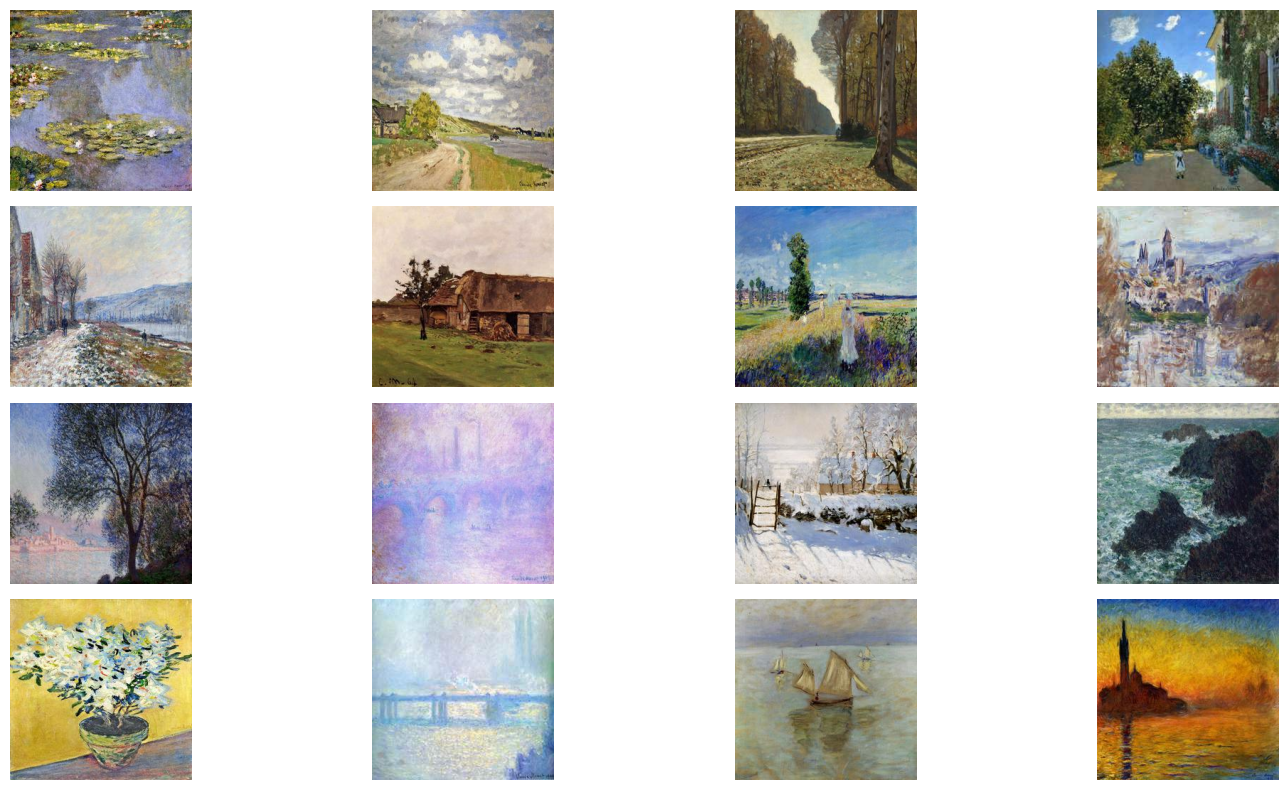

In [10]:
display_multiple_img(monet_images_path, 4, 4)

In [11]:
display_multiple_img(photo_images_path, 4, 4)

# Skeet plots

In [12]:
def styling():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        plt.xticks([])
        plt.yticks([])

In [13]:
def hist(image_path):
    plt.figure(figsize=(16, 3))
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    styling()
    
    custom_colors = ["#ef233c", "#76da71", "#2667ff","#aea3b0"]
    labels = ['Red Channel', 'Green Channel', 'Blue Channel','Total']
    
    for i in range(1,4):
        plt.subplot(1, 5, i+1)
        plt.hist(img[:, :, i-1].reshape(-1),bins=64,color=custom_colors[i-1],alpha = 0.6)
        plt.xlabel(labels[i-1],fontsize=10)
        styling()
        
    plt.subplot(1, 5, 5)
    plt.hist(img.reshape(-1),bins=128,color=custom_colors[3],alpha = 0.6)
    plt.xlabel(labels[3],fontsize=10)
    styling()
    plt.show()

In [14]:
def display_hist(images_paths):
        for ind,image_path in enumerate(images_paths):
            if (ind<6):
                hist(image_path)

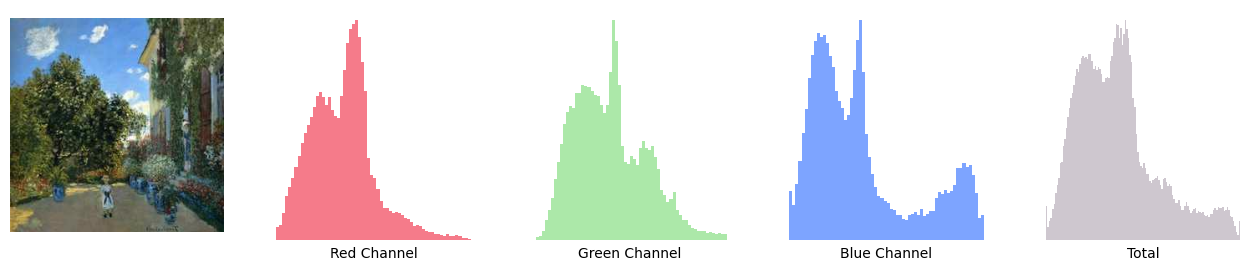

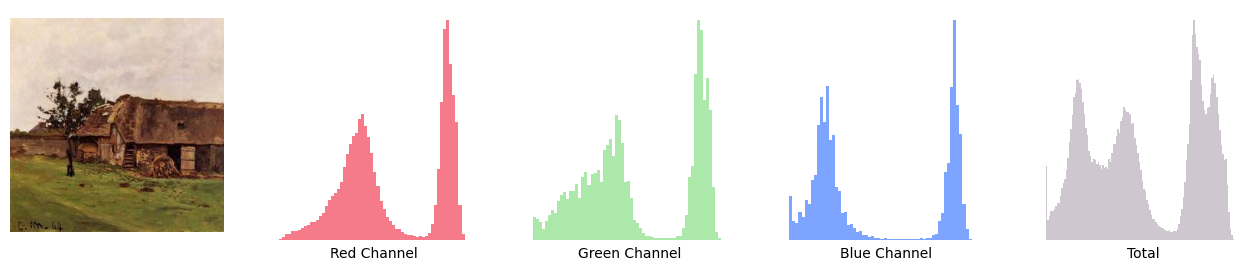

In [15]:
display_hist(monet_images_path)

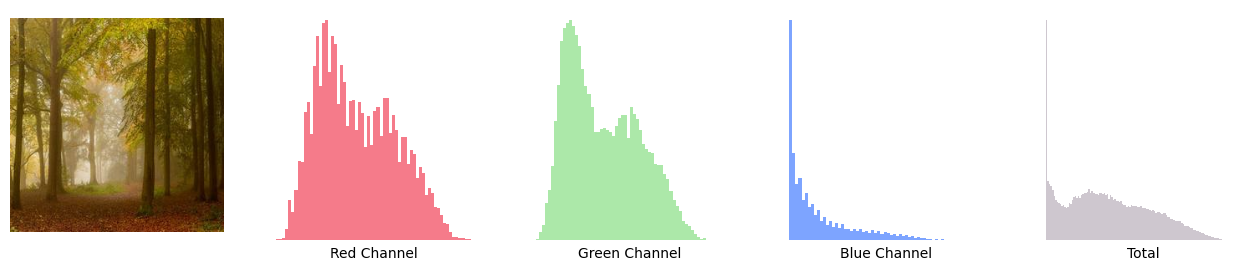

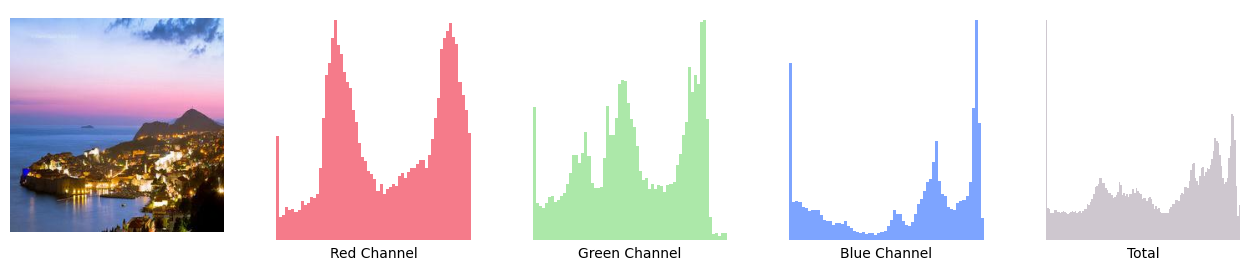

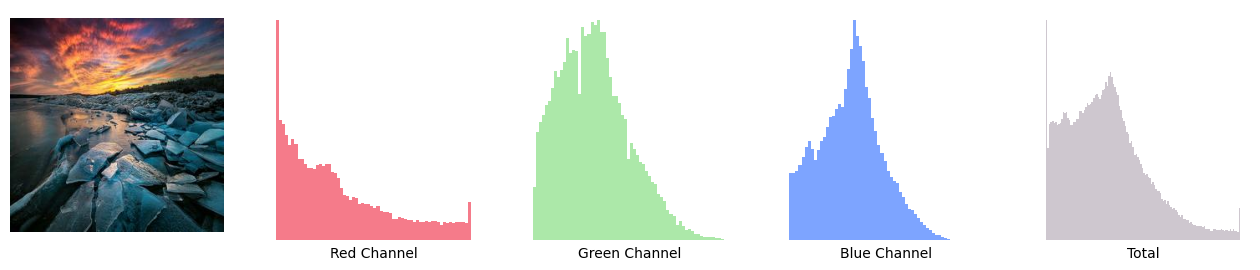

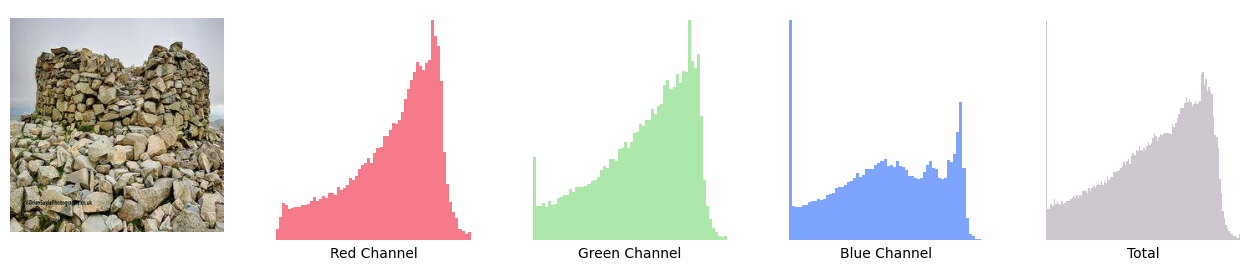

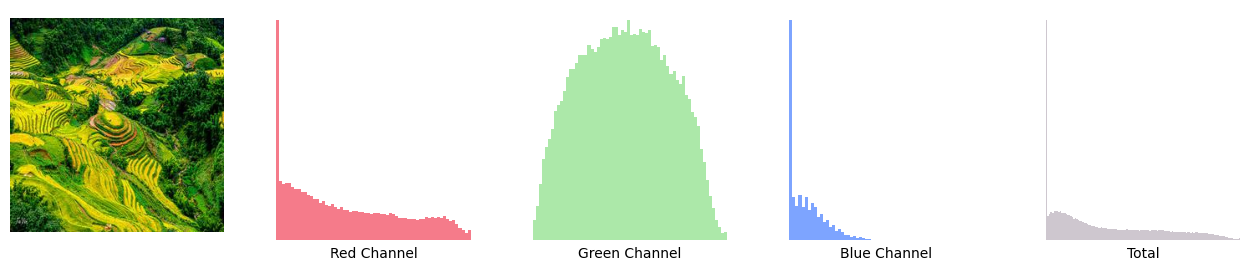

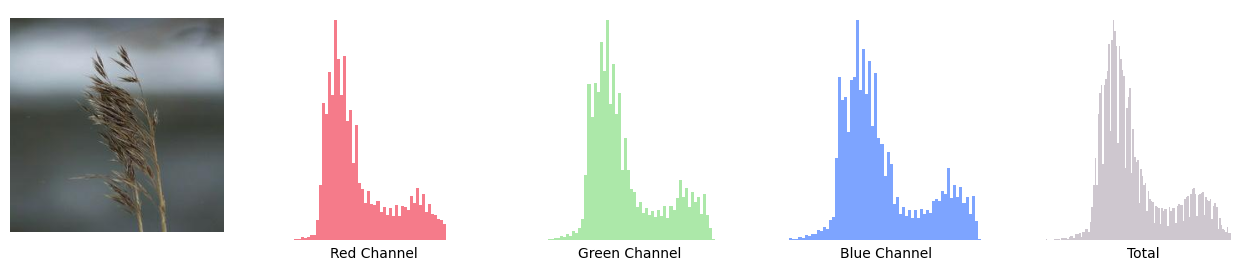

In [16]:
display_hist(photo_images_path)

# Take the train

In [17]:
class GAN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.picasso = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
        self.critic = nn.Sequential(
            nn.Linear(out_size, 1),
            nn.Sigmoid()
        )
    def forward(self, ins):
        return self.picasso(ins)
    def gan_forward(self, ins):
        return self.critic(ins)
    def __call__(self, ins):
        return self.forward(ins)

In [18]:
net = GAN(10, 200, 3 * 256 * 256).to(device)
net.gan_forward(net(torch.randn(10).to(device)))

tensor([0.5704], grad_fn=<SigmoidBackward0>)

In [19]:
num_epochs = 2
batch_size = 2
train_len = len(images)
num_steps = (train_len//batch_size) * num_epochs

lr = 0.0001
optimG = torch.optim.AdamW(net.picasso.parameters(), lr=lr)
optimD = torch.optim.SGD(net.critic.parameters(), lr=lr)

In [20]:
for step in range(num_steps):
    d_batch_real = images[torch.randint(1, train_len-1, (batch_size//2,))]
    d_batch_gen = net(torch.randn(batch_size//2, 10).to(device))
    d_batch = torch.cat((d_batch_real, d_batch_gen)).to(device)
    d_ys = torch.cat((torch.zeros(batch_size//2, 1), torch.ones(batch_size//2, 1))).to(device)
    d_out = net.gan_forward(d_batch)
    
    d_loss = nn.functional.binary_cross_entropy(d_out, d_ys)
    optimD.zero_grad()
    d_loss.backward()
    optimD.step()
    
    g_batch = torch.randn(batch_size, 10).to(device)
    g_out = net(g_batch)
    
    g_loss = net.gan_forward(g_out).sum() / len(g_out)
    optimG.zero_grad()
    g_loss.backward()
    optimG.step()
    
    if step % 100 == 0:
        print("Step", str(step) + ", loss D:", str(d_loss.item()) + ", loss G:", g_loss.item())

Step 0, loss D: 0.6908227205276489, loss G: 0.6204918026924133
Step 100, loss D: 1.9396907091140747, loss G: 0.493696928024292
Step 200, loss D: 4.633302211761475, loss G: 0.062348317354917526
Step 300, loss D: 1.08939528465271, loss G: 0.01659643091261387
Step 400, loss D: 8.912225723266602, loss G: 0.8104151487350464
Step 500, loss D: 50.073726654052734, loss G: 0.9570255279541016
Step 600, loss D: 2.7115254402160645, loss G: 0.3718927204608917
Step 700, loss D: 1.1222476959228516, loss G: 0.40500861406326294
Step 800, loss D: 1.025169849395752, loss G: 0.5339240431785583
Step 900, loss D: 0.8791837692260742, loss G: 0.3364724814891815
Step 1000, loss D: 0.6071220636367798, loss G: 0.5375267267227173
Step 1100, loss D: 0.4749186635017395, loss G: 0.29588720202445984
Step 1200, loss D: 0.31594938039779663, loss G: 0.7232334613800049
Step 1300, loss D: 0.5028011798858643, loss G: 0.22933337092399597
Step 1400, loss D: 0.7008432149887085, loss G: 0.8009657859802246
Step 1500, loss D: 0.

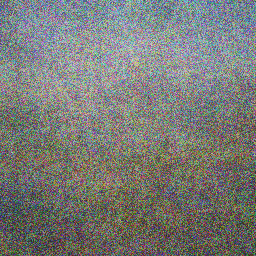

In [21]:
with torch.no_grad():
    ins = torch.randn(10).to(device)
    net_out = net(ins).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(net_out)
    display(image)

# Create a submission

In [22]:
import PIL
! mkdir ../images

for i in range(8000):
    seed = torch.randn(10).to(device)
    out = net(seed).view(3, 256, 256)
    image = torchvision.transforms.functional.to_pil_image(out)
    image.save("../images/" + str(i) + ".jpg")
    i += 1

import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
print("Successfully saved as compressed file")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Successfully saved as compressed file
